In [311]:
import os
import torch
import argparse
import numpy as np

from engine.logger import Logger
from engine.solver import Trainer
from Data.build_dataloader import build_dataloader, build_dataloader_cond
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one
from Utils.io_utils import load_yaml_config, seed_everything, merge_opts_to_config, instantiate_from_config
from Utils.metric_utils import visualization

import sys
import time
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from tqdm import tqdm
from ema_pytorch import EMA
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from Utils.io_utils import instantiate_from_config, get_model_parameters_info


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman') # 设置全局字体

import umap                         # 注意版本对应 numba0.56.4到0.58.1 对应 numpy1.23.4
import seaborn as sns 

from pypots.utils.metrics import calc_mse,calc_rmse,calc_mae
import random



In [312]:
def visualization2(ori, gen):
    
    Number = ori.shape[0]
    
    max_sample = min([4000, Number])       # 最多取4000个样本
    idx = np.random.permutation(Number)[ :max_sample]

    ori1 = np.asarray(ori)[idx]
    gen1 = np.asarray(gen)[idx]

    ori1 = np.mean(ori1, 2) 
    gen1 = np.mean(gen1, 2) 


    '上部分为原样本 下部分为生成样本'
    concat_data = np.concatenate((ori1, gen1), axis=0)
    
    pca = PCA(2)     
    pca_res = pca.fit_transform(concat_data)

    tsne = TSNE(n_components=2, verbose=1, perplexity=40,random_state=20,n_iter=500) 
    tsne_res = tsne.fit_transform(concat_data) 

    umap_ = umap.UMAP(random_state=42)
    umap_res = umap_.fit_transform(concat_data)
    
    
    fig = plt.figure(figsize=(19,4))
    plt.subplot(1,4,1)
    
    '0到2000索引的为原样本'
    plt.scatter(pca_res[:2000,0],pca_res[:2000,1], s=15, c='#ff7f0e')
    plt.scatter(pca_res[max_sample:max_sample+2000,0],pca_res[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
    plt.xlabel('(a)',fontsize=25)
    
    plt.subplot(1,4,2)
    plt.scatter(tsne_res[:2000,0],tsne_res[:2000,1],  s=15,  c='#ff7f0e')
    plt.scatter(tsne_res[max_sample:max_sample+2000,0],tsne_res[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
    plt.xlabel('(b)',fontsize=25)

    plt.subplot(1,4,3)
    plt.scatter(umap_res[:2000, 0], umap_res[:2000, 1],  cmap='Spectral', s=15,  c='#ff7f0e')
    plt.scatter(umap_res[max_sample:max_sample+2000, 0], umap_res[max_sample:max_sample+2000, 1],  cmap='Spectral', s=15, c='#1f77b4')
    plt.xlabel('(c)',fontsize=25)

    
    plt.subplot(1,4,4)
    sns.distplot(ori[:,:,1], hist=False, color = '#ff7f0e' )
    sns.distplot(gen[:,:,1], hist=False, color = '#1f77b4' )  
    plt.xlabel('(d)',fontsize=25)
    
    
    plt.savefig('pca等合成图',dpi=500, bbox_inches='tight' )
    plt.savefig('pca等合成图.pdf', bbox_inches='tight')

In [313]:
def parse_args():
    parser = argparse.ArgumentParser(description='PyTorch Training Script')
    parser.add_argument('--name', type=str, default=None)

    parser.add_argument('--config_file', type=str, default=None, 
                        help='path of config file')
    parser.add_argument('--output', type=str, default='OUTPUT', 
                        help='directory to save the results')
    parser.add_argument('--tensorboard', action='store_true', 
                        help='use tensorboard for logging')

    # args for random

    parser.add_argument('--cudnn_deterministic', action='store_true', default=False,
                        help='set cudnn.deterministic True')
    parser.add_argument('--seed', type=int, default=10, 
                        help='seed for initializing training.')
    parser.add_argument('--gpu', type=int, default=None,
                        help='GPU id to use. If given, only the specific gpu will be'
                        ' used, and ddp will be disabled')
    
    # args for training
    parser.add_argument('--train', action='store_true', default=False, help='Train or Test.')
    parser.add_argument('--sample', type=int, default=0, 
                        choices=[0, 1], help='Condition or Uncondition.')
    parser.add_argument('--mode', type=str, default='infill',
                        help='Infilling or Forecasting.')
    parser.add_argument('--milestone', type=int, default=10)

    parser.add_argument('--missing_ratio', type=float, default=0., help='Ratio of Missing Values.')
    parser.add_argument('--pred_len', type=int, default=0, help='Length of Predictions.')
    
    
    # args for modify config
    parser.add_argument('opts', help='Modify config options using the command-line',
                        default=None, nargs=argparse.REMAINDER)  

    args = parser.parse_args(args=[])
    args.save_dir = os.path.join(args.output, f'{args.name}')

    return args


In [319]:
args = parse_args()

# data_name = 'SP500'
# data_name = 'ETTh1'
# data_name = 'Energy'
# data_name = 'MuJoCo'
# data_name = 'fmri'
# data_name = 'exchange_rate'
data_name = 'weather'


if data_name == 'SP500':
    args.config_file =  './Config/SP500.yaml'
    
elif data_name == 'ETTh1':
    args.config_file =  './Config/ETTh1.yaml'

elif data_name == 'Energy':
    args.config_file =  './Config/Energy.yaml'
    
elif data_name == 'MuJoCo':
    args.config_file =  './Config/MuJoCo.yaml'
    
elif data_name == 'fmri':
    args.config_file =  './Config/fmri.yaml'

elif data_name == 'exchange_rate':
    args.config_file =  './Config/exchange_rate.yaml'
    
elif data_name == 'weather':
    args.config_file =  './Config/weather.yaml'
    
    
# args.config_file =  './Config/stocks.yaml'

args.gpu =  0
args.train = True
print(args)

Namespace(name=None, config_file='./Config/weather.yaml', output='OUTPUT', tensorboard=False, cudnn_deterministic=False, seed=10, gpu=0, train=True, sample=0, mode='infill', milestone=10, missing_ratio=0.0, pred_len=0, opts=[], save_dir='OUTPUT\\None')


In [320]:
if args.seed is not None:
    seed_everything(args.seed)

if args.gpu is not None:
    torch.cuda.set_device(args.gpu)

config = load_yaml_config(args.config_file)
config = merge_opts_to_config(config, args.opts)


config['dataloader']['batch_size'] = 128
print(config)

beta_schedule = config['model']['params']['beta_schedule'] 
timesteps = config['model']['params']['timesteps'] 
print(beta_schedule, timesteps)

Global seed set to 10
{'model': {'target': 'Models.interpretable_diffusion.gaussian_diffusion.Diffusion_TS', 'params': {'seq_length': 60, 'feature_size': 16, 'n_layer_enc': 4, 'n_layer_dec': 3, 'd_model': 96, 'timesteps': 1000, 'sampling_timesteps': 1000, 'loss_type': 'l1', 'beta_schedule': 'cosine', 'n_heads': 4, 'mlp_hidden_times': 4, 'attn_pd': 0.0, 'resid_pd': 0.0, 'kernel_size': 1, 'padding_size': 0}}, 'solver': {'base_lr': 1e-05, 'max_epochs': 25000, 'results_folder': './Checkpoints_energy', 'gradient_accumulate_every': 2, 'save_cycle': 2500, 'ema': {'decay': 0.995, 'update_interval': 10}, 'scheduler': {'target': 'engine.lr_sch.ReduceLROnPlateauWithWarmup', 'params': {'factor': 0.5, 'patience': 5000, 'min_lr': 1e-05, 'threshold': 0.1, 'threshold_mode': 'rel', 'warmup_lr': 0.0008, 'warmup': 500, 'verbose': False}}}, 'dataloader': {'train_dataset': {'target': 'Utils.Data_utils.real_datasets.CustomDataset', 'params': {'name': 'energy', 'proportion': 1.0, 'data_root': './Data/dataset

In [321]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

if data_name == 'SP500':
    load_data = np.load( './Data/datasets/sp500.npy')

elif data_name == 'ETTh1':
    load_data = np.load( './Data/datasets/ETTh1.npy')
    
elif data_name == 'Energy':
    load_data = np.load( './Data/datasets/Energy.npy')

elif data_name == 'MuJoCo':
    load_data = np.load( './Data/datasets/MuJoCo.npy')
    
elif data_name == 'fmri':
    load_data = np.load( './Data/datasets/fmri.npy')
    
elif data_name == 'exchange_rate':
    load_data = np.load( './Data/datasets/exchange_rate.npy')
    
elif data_name == 'weather':
    load_data = np.load( './Data/datasets/weather.npy')
    
    
# np.random.seed(11)
np.random.shuffle(load_data)
# train_data = load_data[ 0: int( load_data.shape[0]*0.8) ]
# test_data = load_data[ int( load_data.shape[0]*0.8): ]    

train_data = load_data
test_data = load_data
    
    
print(train_data.shape, test_data.shape)
# print(train_data[0])

Numble = train_data.shape[0]
Length = train_data.shape[1]
Feature = train_data.shape[2]
Batchsize = 200


class MyDataset(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        x = torch.tensor(self.X_data[idx], dtype=torch.float32)  # 转换为 Tensor
        return x   
                    
dataset = MyDataset(train_data)    
dataloader = DataLoader(dataset, batch_size=Batchsize, shuffle=True)

def cycle(dl):         
    while True:
        for data in dl:
            yield data
            
dl = cycle( dataloader )
print( next(dl).shape )

(5264, 60, 16) (5264, 60, 16)
torch.Size([200, 60, 16])


In [301]:
def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def exists(x):
    return x is not None

from Models.interpretable_diffusion.model_utils import default, identity, extract
from Models.interpretable_diffusion.gaussian_diffusion import linear_beta_schedule, cosine_beta_schedule, Diffusion_TS
import torch.nn.functional as F


shape = (Numble, Length, Feature)
print(shape)

# num_timesteps = model.num_timesteps
# print(num_timesteps)

(5264, 60, 16)


# 训练无条件整流模型

In [263]:
rf_model = instantiate_from_config(config['model']).cuda()
print(rf_model.use_ff, rf_model.num_timesteps, rf_model.loss_type)
print(rf_model.sampling_timesteps, rf_model.fast_sampling)

True 1000 l1
1000 False


In [264]:
device = rf_model.betas.device
epoch = 500
iteration = int( epoch * (Numble/Batchsize) )
print(iteration)

gradient_accumulate_every = config['solver']['gradient_accumulate_every'] 


9850


In [265]:
start_lr = config['solver'].get('base_lr', 1.0e-4)
ema_decay = config['solver']['ema']['decay']
ema_update_every = config['solver']['ema']['update_interval']
ema = EMA(rf_model, beta=ema_decay, update_every=ema_update_every).to(device)

opt = Adam(filter(lambda p: p.requires_grad, rf_model.parameters()), lr=start_lr, betas=[0.9, 0.96])
# print(opt)

sc_cfg = config['solver']['scheduler']
sc_cfg['params']['optimizer'] = opt    # 配置里添加了一个优化器参数
sch = instantiate_from_config(sc_cfg)   # 导入了 engine.lr_sch.ReduceLROnPlateauWithWarmup
# print(sch)



In [266]:
ds = 1 / torch.tensor([2 ** i for i in range(1, 8)]).to(device)
ds_p = torch.ones((ds.shape[0],)).to(device) / ds.shape[0]

d = ds[ds_p.multinomial(10, replacement=True).to(device)]
print(d, d.shape)

t = torch.rand(size=(10, 1), device=device)
print(t,t.shape)


def reshape_coefs(t):
    return t.reshape((t.shape[0], 1,  1))

# t = torch.rand( size=(b,), device=device)
# print(t)



tensor([0.0078, 0.2500, 0.0156, 0.5000, 0.0312, 0.2500, 0.2500, 0.5000, 0.0625,
        0.0156], device='cuda:0') torch.Size([10])
tensor([[0.4674],
        [0.2601],
        [0.3044],
        [0.9964],
        [0.8242],
        [0.1826],
        [0.8790],
        [0.6630],
        [0.9736],
        [0.1960]], device='cuda:0') torch.Size([10, 1])


In [13]:
padding_masks = None
clip_x_start = False
clip_denoised = True

loss_list = []

pbar = tqdm( total=iteration )   

step = 0

while step < iteration:
    total_loss = 0.

    for _ in range(gradient_accumulate_every):
    
        x_1 = next(dl).to(device)           # [128, 30, 6]  前面对dl用了cycle 类似iter 可以取数据     
        x_0 = torch.randn_like(x_1)
        b, c, n, = x_0.shape
        K = int(b * 1)

        t = torch.rand( size=(b,), device=device)      # [128]
        t_re = reshape_coefs(t)                               # [128, 1, 1]

        x_t = t_re * x_1 + (1. - t_re) * x_0     # x0为起点 x1为终点

        d = ds[ds_p.multinomial(b, replacement=True).to(device)]   # [128]
        d[:K] = 0  

        padding_masks = torch.ones(b, c, dtype=bool, device=x_t.device)
        
        v_pred = rf_model.output( x_t[:K], t[:K], d=d[:K], padding_masks=padding_masks) 
        
        fm_loss = F.mse_loss(v_pred, (x_1[:K] - x_0[:K]), reduction="mean")
#         fm_loss = F.l1_loss(v_pred, (x_1[:K] - x_0[:K]), reduction="mean")
    
        loss_list.append(fm_loss.item())
        
        fm_loss = fm_loss / gradient_accumulate_every
        fm_loss.backward()                      # 梯度反传了 但是还没有用step 模型还没更新 后面要剪裁
        total_loss += fm_loss.item()
    
    
    clip_grad_norm_(rf_model.parameters(), 1.0)   # 剪裁参数 再优化器step  新建的优化器也step
    opt.step()
    sch.step(total_loss)    # 这一步影响最大  不用这个的话 loss收敛有问题 且波动大
    opt.zero_grad()
    step += 1
    ema.update()  
    
    pbar.update(1)
    
pbar.close()

100%|████████████████████████████████████████████████████████████████████████████| 24942/24942 [50:28<00:00,  8.24it/s]


49884 0.18349984288215637
[0.47231512133739273, 0.39737895523099637, 0.4433260833743776, 0.43131763577468024, 0.39694827522208714, 0.41837743583040776, 0.42817957453700395, 0.4149535685727667, 0.43732716347988954, 0.41921908096715577]


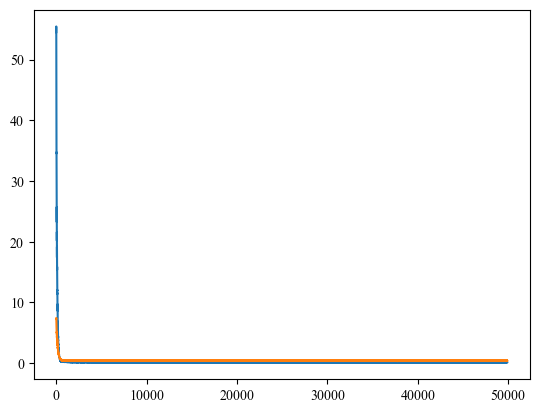

In [16]:
print(len(loss_list), total_loss)
# print(loss_list[-10:] )

rmse = list( map(lambda x: x ** (1/2), loss_list) )
print(rmse[-10:])

plt.figure()
plt.plot(loss_list)
plt.plot(rmse)

In [17]:
# torch.save( rf_model.state_dict(),"./checkpoint/rectified_flow/sp500_rf.pth" )
# torch.save( ema.state_dict(),"./checkpoint/rectified_flow/sp500_ema_rf.pth" )

# torch.save( rf_model.state_dict(),"./checkpoint/rectified_flow/ETTh1_rf.pth" )
# torch.save( ema.state_dict(),"./checkpoint/rectified_flow/ETTh1_ema_rf.pth" )

# torch.save( rf_model.state_dict(),"./checkpoint/rectified_flow/Energy_rf.pth" )
# torch.save( ema.state_dict(),"./checkpoint/rectified_flow/Energy_ema_rf.pth" )

# torch.save( rf_model.state_dict(),"./checkpoint/rectified_flow/MuJoCo_rf.pth" )
# torch.save( ema.state_dict(),"./checkpoint/rectified_flow/MuJoCo_ema_rf.pth" )

# torch.save( rf_model.state_dict(),"./checkpoint/rectified_flow/fmri_rf.pth" )
# torch.save( ema.state_dict(),"./checkpoint/rectified_flow/fmri_ema_rf.pth" )

In [187]:
rf_model = instantiate_from_config(config['model']).cuda()

# rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/exchange_rate_rf.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/exchange_rate_ema_rf.pth"  ))

# rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/weather_rf.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/weather_ema_rf.pth"  ))

# rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/sp500_rf.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/sp500_ema_rf.pth"  ))

rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/ETTh1_rf.pth"  ))
ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/ETTh1_ema_rf.pth"  ))

# rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/Energy_rf.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/Energy_ema_rf.pth"  ))

# rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/MuJoCo_rf.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/MuJoCo_ema_rf.pth"  ))

# rf_model.load_state_dict(torch.load( "./checkpoint/rectified_flow/fmri_rf.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/rectified_flow/fmri_ema_rf.pth"  ))

<All keys matched successfully>

# synthesis in large sampling step by rectified flow

In [161]:
n_steps = 30
eps = 1e-8
# eps = 0
shape = (Numble, Length, Feature)


x_t = torch.randn(shape, device=device)
b, c, n, = x_t.shape

padding_masks = torch.ones(b, c, dtype=bool, device=device)

d = ds[ds_p.multinomial(b, replacement=True).to(device)]
d[:b] = 0 
print( d.shape )


t = torch.linspace(eps, 1 - eps, n_steps+1 ).to(device)
# print(len(t))

for i in range(1, len(t)):
    t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))
#     d_batch = d.unsqueeze(0).repeat((b,))
    
    with torch.no_grad():
        
        v_pred = ema.ema_model.output(x_t, t_batch, d=d, padding_masks=padding_masks) 

    x_t = x_t + (t[i] - t[i - 1]) * v_pred

print(x_t.shape)

torch.Size([3478])
torch.Size([3478, 30, 7])


In [95]:
# visualization(ori_data=train_data, generated_data=x_t.detach().cpu().numpy(), analysis='pca', compare=train_data.shape[0])

C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6956 samples in 0.000s...
[t-SNE] Computed neighbors for 6956 samples in 0.162s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6956
[t-SNE] Computed conditional probabilities for sample 2000 / 6956
[t-SNE] Computed conditional probabilities for sample 3000 / 6956
[t-SNE] Computed conditional probabilities for sample 4000 / 6956
[t-SNE] Computed conditional probabilities for sample 5000 / 6956
[t-SNE] Computed conditional probabilities for sample 6000 / 6956
[t-SNE] Computed conditional probabilities for sample 6956 / 6956
[t-SNE] Mean sigma: 0.071340
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.610374
[t-SNE] KL divergence after 500 iterations: 2.068730


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\PC123\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\PC123\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\PC123\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `k

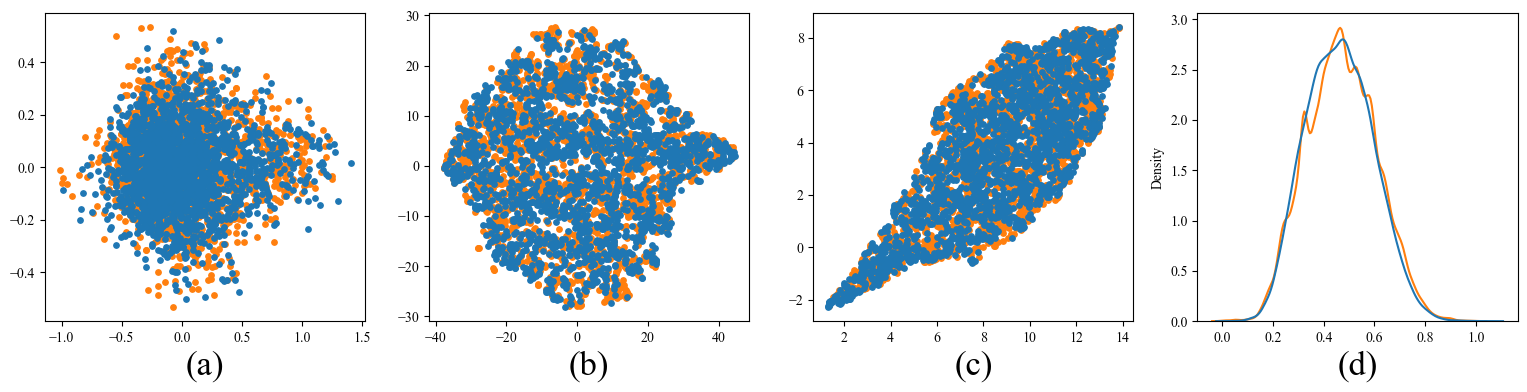

In [241]:
visualization2(train_data, x_t.detach().cpu().numpy() )

# synthesis in few-step by rectified flow

In [242]:
eps = 1e-8
shape = (Numble, Length, Feature)
b, c, n, = x_t.shape
padding_masks = torch.ones(b, c, dtype=bool, device=device)
d = ds[ds_p.multinomial(b, replacement=True).to(device)]
d[:b] = 0 

res_list = []
for n_steps in [1,3,5,10]:
    x_t = torch.randn(shape, device=device)
    
    t = torch.linspace(eps, 1 - eps, n_steps+1 ).to(device)

    for i in range(1, len(t)):
        t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))
    #     d_batch = d.unsqueeze(0).repeat((b,))

        with torch.no_grad():

            v_pred = ema.ema_model.output(x_t, t_batch, d=d, padding_masks=padding_masks) 

        x_t = x_t + (t[i] - t[i - 1]) * v_pred
        
    res_list.append(x_t.detach().cpu().numpy())
print(len(res_list))

4


In [243]:
def visualization3(ori, gen):
    Number = ori.shape[0]
    max_sample = min([4000, Number])       # 最多取4000个样本
    idx = np.random.permutation(Number)[ :max_sample]
    
    ori1 = np.asarray(ori)[idx]
    ori1 = np.mean(ori1, 2) 
    
    gen1 = np.asarray(gen[0])[idx]
    gen2 = np.asarray(gen[1])[idx]
    gen3 = np.asarray(gen[2])[idx]
    gen4 = np.asarray(gen[3])[idx]
      
    gen1 = np.mean(gen1, 2) 
    gen2 = np.mean(gen2, 2) 
    gen3 = np.mean(gen3, 2) 
    gen4 = np.mean(gen4, 2) 

    concat_data1 = np.concatenate((ori1, gen1), axis=0)
    concat_data2 = np.concatenate((ori1, gen2), axis=0)
    concat_data3 = np.concatenate((ori1, gen3), axis=0)
    concat_data4 = np.concatenate((ori1, gen4), axis=0)
    
    pca = PCA(2)     
    pca_res1 = pca.fit_transform(concat_data1)
    pca = PCA(2)
    pca_res2 = pca.fit_transform(concat_data2)
    pca = PCA(2)
    pca_res3 = pca.fit_transform(concat_data3)
    pca = PCA(2)
    pca_res4 = pca.fit_transform(concat_data4)

    fig = plt.figure(figsize=(19,4))
    plt.subplot(1,4,1)
    
    '0到2000索引的为原样本'
    plt.scatter(pca_res1[:2000,0],pca_res1[:2000,1], s=15, c='#ff7f0e')
    plt.scatter(pca_res1[max_sample:max_sample+2000,0],pca_res1[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
#     plt.xlabel('(a)',fontsize=25)
#     plt.title('Step 1',fontsize=25)
    
    plt.subplot(1,4,2)
    plt.scatter(pca_res2[:2000,0],pca_res2[:2000,1], s=15, c='#ff7f0e')
    plt.scatter(pca_res2[max_sample:max_sample+2000,0],pca_res2[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
#     plt.xlabel('(b)',fontsize=25)
#     plt.title('Step 3',fontsize=25)
    
    plt.subplot(1,4,3)
    plt.scatter(pca_res3[:2000,0],pca_res3[:2000,1], s=15, c='#ff7f0e')
    plt.scatter(pca_res3[max_sample:max_sample+2000,0],pca_res3[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
#     plt.xlabel('(c)',fontsize=25)
#     plt.title('Step 5',fontsize=25)
    
    plt.subplot(1,4,4)
    plt.scatter(pca_res4[:2000,0],pca_res4[:2000,1], s=15, c='#ff7f0e')
    plt.scatter(pca_res4[max_sample:max_sample+2000,0],pca_res4[max_sample:max_sample+2000,1], s=15, c='#1f77b4')
#     plt.xlabel('(d)',fontsize=25)
#     plt.title('Step 10',fontsize=25)
    
    
#     plt.savefig('pca渐变图',dpi=500, bbox_inches='tight' )
#     plt.savefig('pca渐变图.pdf', bbox_inches='tight')

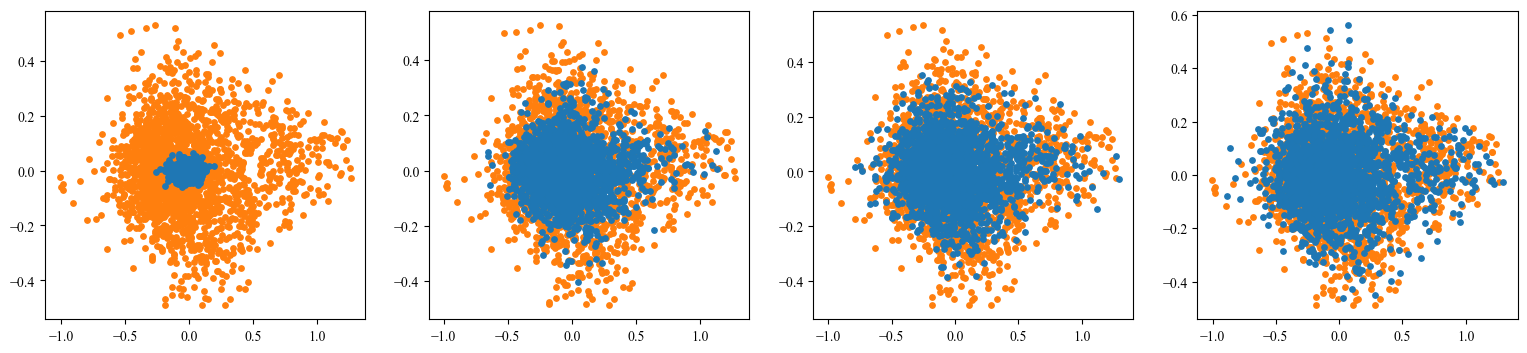

In [244]:
visualization3(train_data, res_list)

# training shortcut

In [303]:
shortcut = instantiate_from_config(config['model']).cuda()
print(shortcut.use_ff, shortcut.num_timesteps, shortcut.loss_type)
print(shortcut.sampling_timesteps, shortcut.fast_sampling)

True 1000 l1
1000 False


In [304]:
epoch = 500
iteration = int( epoch * (Numble/Batchsize) )
print(iteration)

device = shortcut.betas.device
gradient_accumulate_every = config['solver']['gradient_accumulate_every'] 

13160


In [305]:
start_lr = config['solver'].get('base_lr', 1.0e-4)
ema_decay = config['solver']['ema']['decay']
ema_update_every = config['solver']['ema']['update_interval']
ema = EMA(shortcut, beta=ema_decay, update_every=ema_update_every).to(device)

opt = Adam(filter(lambda p: p.requires_grad, shortcut.parameters()), lr=start_lr, betas=[0.9, 0.96])
# print(opt)

sc_cfg = config['solver']['scheduler']
sc_cfg['params']['optimizer'] = opt    # 配置里添加了一个优化器参数
sch = instantiate_from_config(sc_cfg)   # 导入了 engine.lr_sch.ReduceLROnPlateauWithWarmup
# print(sch)


In [306]:
ds = 1 / torch.tensor([2 ** i for i in range(1, 8)]).to(device)
ds_p = torch.ones((ds.shape[0],)).to(device) / ds.shape[0]

d = ds[ds_p.multinomial(5, replacement=True).to(device)]
print(d, d.shape)

t = torch.rand(size=(10, 1), device=device)
print(t,t.shape)


def reshape_coefs(t):
    return t.reshape((t.shape[0], 1,  1))

K = int(Batchsize * 0.75)
print(K)

tensor([0.0078, 0.2500, 0.0156, 0.5000, 0.0312], device='cuda:0') torch.Size([5])
tensor([[0.4674],
        [0.2601],
        [0.3044],
        [0.9964],
        [0.8242],
        [0.1826],
        [0.8790],
        [0.6630],
        [0.9736],
        [0.1960]], device='cuda:0') torch.Size([10, 1])
150


In [29]:
padding_masks = None
clip_x_start = False
clip_denoised = True

loss_fm = []
loss_consis = []
loss_total = []

pbar = tqdm( total=iteration )   

step = 0
while step < iteration:
    total_loss = 0.

    for _ in range(gradient_accumulate_every):
    
        x_1 = next(dl).to(device)           # [128, 30, 6]  前面对dl用了cycle 类似iter 可以取数据     
        x_0 = torch.randn_like(x_1)
        b, c, n, = x_0.shape
        K = int(b * 0.75)

        t = torch.rand( size=(b,), device=device)      # [128]
        t_re = reshape_coefs(t)                               # [128, 1, 1]

        x_t = t_re * x_1 + (1. - t_re) * x_0     # x0为起点 x1为终点

        d = ds[ds_p.multinomial(b, replacement=True).to(device)]   # [128]
        d[:K] = 0  

        padding_masks = torch.ones(b, c, dtype=bool, device=x_t.device)
            
            
        v_pred = shortcut.output( x_t[:K], t[:K], d=d[:K], padding_masks=padding_masks[:K]) 
#         print(x_t[:K].shape,t[:K].shape, d[:K].shape,  padding_masks[:K].shape )
        
        
        fm_loss = F.mse_loss(v_pred, (x_1[:K] - x_0[:K]), reduction="mean")

    
        'shortcut训练'
        '分两次计算采样步 后面一次性计算2倍采样步'
#         with torch.no_grad():
#         print( x_t.shape,t.shape,d.shape, x_t[K:].shape, t[K:].shape, d[K:].shape  )
        s_t =  shortcut.output( x_t[K:], t[K:], d=d[K:], padding_masks=padding_masks[K:]) 
        
    
    

        d_re = reshape_coefs(d[K:])  
#         print(s_t.shape, d_re.shape, x_t[K:].shape)


        x_td = x_t[K:] + s_t * d_re
#         print(x_td.shape, t[K:].shape, d[K:].shape, (t[K:]+ d[K:]).shape, padding_masks[K:].shape )


        s_td = shortcut.output( x_td, t[K:]+ d[K:], d=d[K:], padding_masks=padding_masks[K:]) 
        s_target = (s_t + s_td) / 2 
    
    
    
        v_pred_2 = shortcut.output( x_t[K:], t[K:], d=2*d[K:], padding_masks=padding_masks[K:]) 
    
        consistency_loss = F.mse_loss(v_pred_2, s_target, reduction="mean")
    
        loss = fm_loss + consistency_loss
    
    
        loss_total.append(loss.item())
        loss_fm.append(fm_loss.item())
        loss_consis.append(consistency_loss.item())
        
        
        loss = loss / gradient_accumulate_every
        loss.backward()                      # 梯度反传了 但是还没有用step 模型还没更新 后面要剪裁
        total_loss += loss.item()
    
    
    clip_grad_norm_(shortcut.parameters(), 1.0)   # 剪裁参数 再优化器step  新建的优化器也step
    opt.step()
    sch.step(total_loss)    # 这一步影响最大  不用这个的话 loss收敛有问题 且波动大
    opt.zero_grad()
    step += 1
    ema.update()  
    
    pbar.update(1)
    
pbar.close()


  0%|▎                                                                             | 27/6305 [00:42<2:42:48,  1.56s/it]

  0%|                                                                             | 13/13160 [00:04<1:09:29,  3.15it/s]

KeyboardInterrupt: 

In [ ]:
rmse = list( map(lambda x: x ** (1/2), loss_fm) )
print(rmse[-10:])

print( loss_consis[-10:])

plt.figure()
plt.plot(loss_total[400:])

# plt.figure()
plt.plot(loss_fm[400:])

# plt.figure()
plt.plot(loss_consis[400:])

In [ ]:
# torch.save( shortcut.state_dict(),"./checkpoint/shortcut/sp500_shortcut.pth" )
# torch.save( ema.state_dict(),"./checkpoint/shortcut/sp500_ema_shortcut.pth" )

# torch.save( shortcut.state_dict(),"./checkpoint/shortcut/ETTh1_shortcut.pth" )
# torch.save( ema.state_dict(),"./checkpoint/shortcut/ETTh1_ema_shortcut.pth" )

# torch.save( shortcut.state_dict(),"./checkpoint/shortcut/Energy_shortcut.pth" )
# torch.save( ema.state_dict(),"./checkpoint/shortcut/Energy_ema_shortcut.pth" )

# torch.save( shortcut.state_dict(),"./checkpoint/shortcut/MuJoCo_shortcut.pth" )
# torch.save( ema.state_dict(),"./checkpoint/shortcut/MuJoCo_ema_shortcut.pth" )

# torch.save( shortcut.state_dict(),"./checkpoint/shortcut/fmri_shortcut.pth" )
# torch.save( ema.state_dict(),"./checkpoint/shortcut/fmri_ema_shortcut.pth" )

In [307]:
shortcut = instantiate_from_config(config['model']).cuda()

# shortcut.load_state_dict(torch.load( "./checkpoint/shortcut/sp500_shortcut.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/shortcut/sp500_ema_shortcut.pth"  ))

# shortcut.load_state_dict(torch.load( "./checkpoint/shortcut/exchange_rate_shortcut.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/shortcut/exchange_rate_ema_shortcut.pth"  ))

shortcut.load_state_dict(torch.load( "./checkpoint/shortcut/weather_shortcut.pth"  ))
ema.load_state_dict(torch.load( "./checkpoint/shortcut/weather_ema_shortcut.pth"  ))

# shortcut.load_state_dict(torch.load( "./checkpoint/shortcut/ETTh1_shortcut.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/shortcut/ETTh1_ema_shortcut.pth"  ))

# shortcut.load_state_dict(torch.load( "./checkpoint/shortcut/Energy_shortcut.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/shortcut/Energy_ema_shortcut.pth"  ))

# shortcut.load_state_dict(torch.load( "./checkpoint/shortcut/MuJoCo_shortcut.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/shortcut/MuJoCo_ema_shortcut.pth"  ))

# shortcut.load_state_dict(torch.load( "./checkpoint/shortcut/fmri_shortcut.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/shortcut/fmri_ema_shortcut.pth"  ))

<All keys matched successfully>

# synthesize in large step by shortcut-ts

In [308]:
n_steps = 30
eps = 1e-8
# eps = 0
shape = (Numble, Length, Feature)


# x_t = torch.randn_like(torch.tensor( train_data, dtype=torch.float32) ).to(device)
x_t = torch.randn(shape, device=device)
b, c, n, = x_t.shape

padding_masks = torch.ones(b, c, dtype=bool, device=device)


d = torch.tensor(1 / n_steps).to(device)
t = torch.linspace(eps, 1 - eps, n_steps+1 ).to(device)
# print(len(t))

for i in range(1, len(t)):
    t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))
    d_batch = d.unsqueeze(0).repeat((b,))
    
    with torch.no_grad():
        
        v_pred = ema.ema_model.output(x_t, t_batch, d=d_batch, padding_masks=padding_masks) 

    x_t = x_t + (t[i] - t[i - 1]) * v_pred
    

print( t_batch.shape, d_batch.shape )
print(x_t.shape)

torch.Size([5264]) torch.Size([5264])
torch.Size([5264, 60, 16])


In [293]:
# visualization(ori_data=train_data, generated_data=x_t.detach().cpu().numpy(), analysis='pca', compare=train_data.shape[0])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.000s...


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 8000 samples in 0.218s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.034429
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.534691
[t-SNE] KL divergence after 500 iterations: 1.553825


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\PC123\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\PC123\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\PC123\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `k

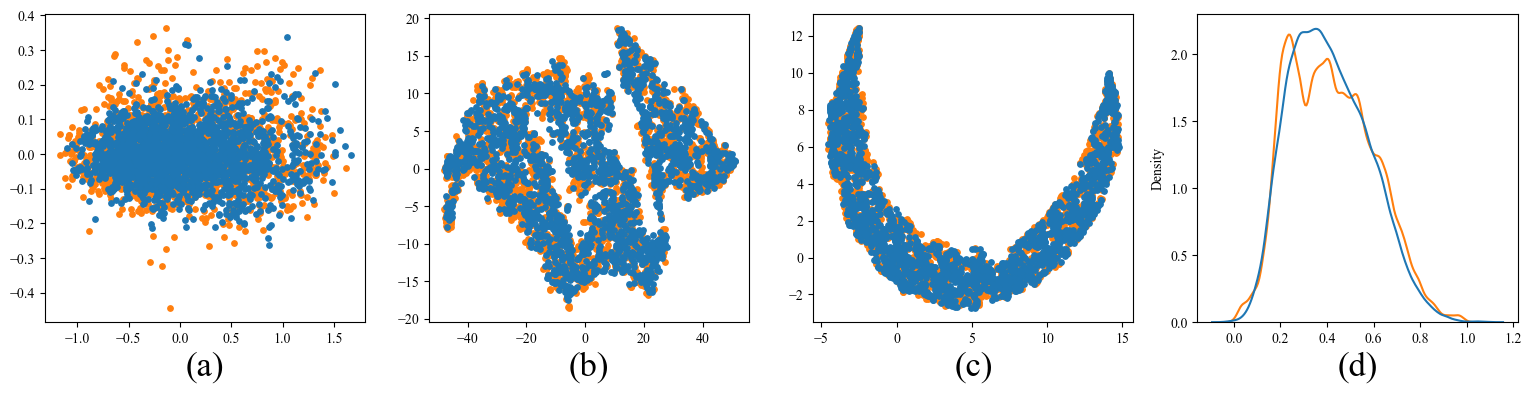

In [309]:
visualization2(train_data, x_t.detach().cpu().numpy() )

# synthesis in few-step by shortcut-ts

In [223]:
eps = 1e-8
shape = (Numble, Length, Feature)
b, c, n, = x_t.shape
padding_masks = torch.ones(b, c, dtype=bool, device=device)

res_list2 = []
for n_steps in[1,3,5,10]:
    x_t = torch.randn(shape, device=device)
    d = torch.tensor(1 / n_steps).to(device)
    t = torch.linspace(eps, 1 - eps, n_steps+1 ).to(device)
    for i in range(1, len(t)):
        t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))
        d_batch = d.unsqueeze(0).repeat((b,))
        with torch.no_grad():
            v_pred = ema.ema_model.output(x_t, t_batch, d=d_batch, padding_masks=padding_masks) 

        x_t = x_t + (t[i] - t[i - 1]) * v_pred
    
    res_list2.append(x_t.detach().cpu().numpy())

print(len(res_list2))

4


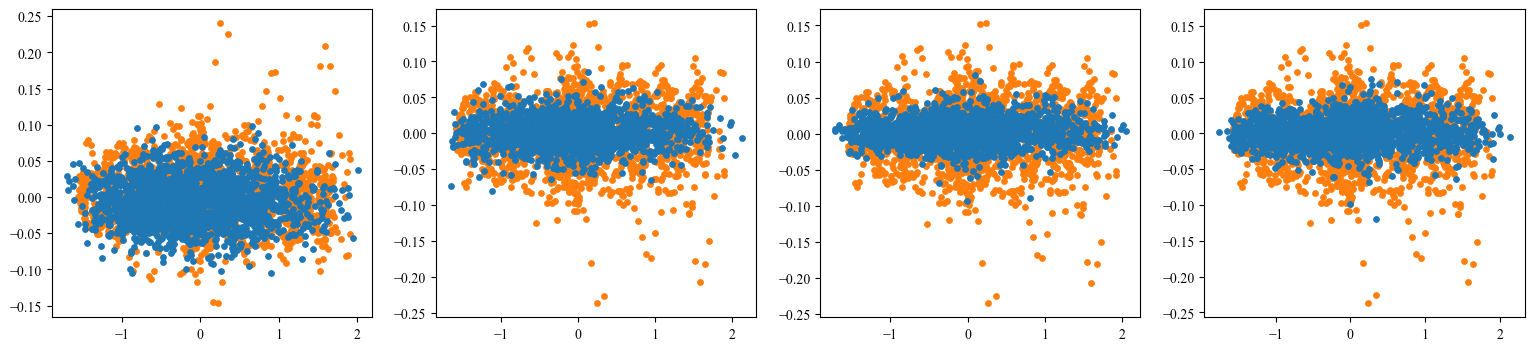

In [224]:
visualization3(train_data, res_list2)

# 二阶欧拉采样

In [164]:
n_steps = 10
eps = 1e-8
# eps = 0
shape = (Numble, Length, Feature)

x_t = torch.randn(shape, device=device)
b, c, n, = x_t.shape

padding_masks = torch.ones(b, c, dtype=bool, device=device)


d = torch.tensor(1 / n_steps).to(device)
t = torch.linspace(eps, 1 - eps, n_steps+1 ).to(device)
# t = torch.linspace(0, 1 , n_steps+1 ).to(device)

for i in range(1, len(t)):
    t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))
    d_batch = d.unsqueeze(0).repeat((b,))
    
    with torch.no_grad():
        
        v_pred = ema.ema_model.output(x_t, t_batch, d=d_batch, padding_masks=padding_masks) 

        x_t_p_dt = x_t + (t[i] - t[i - 1]) * v_pred
        
        t_batch = t[i].unsqueeze(0).repeat((b,))
        
        v_pred_p_dt = ema.ema_model.output(x_t_p_dt, t_batch, d=d_batch, padding_masks=padding_masks) 
        
        v_deriv = (v_pred_p_dt - v_pred)/(t[i] - t[i - 1])
        
    
    x_t = x_t + (t[i] - t[i - 1]) * v_pred  + ( 0.5 *  (t[i] - t[i - 1])**2)  * v_deriv


print( t_batch.shape, d_batch.shape )
print(x_t.shape)

torch.Size([5775]) torch.Size([5775])
torch.Size([5775, 30, 6])


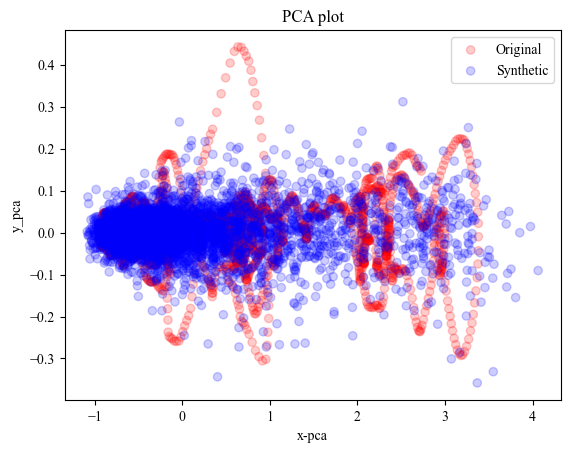

In [165]:
visualization(ori_data=train_data, generated_data=x_t.detach().cpu().numpy(), analysis='pca', compare=train_data.shape[0])

C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.001s...
[t-SNE] Computed neighbors for 8000 samples in 0.188s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.020889
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.442879
[t-SNE] KL divergence after 500 iterations: 1.342796


C:\Users\PC123\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\PC123\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\PC123\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\PC123\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `k

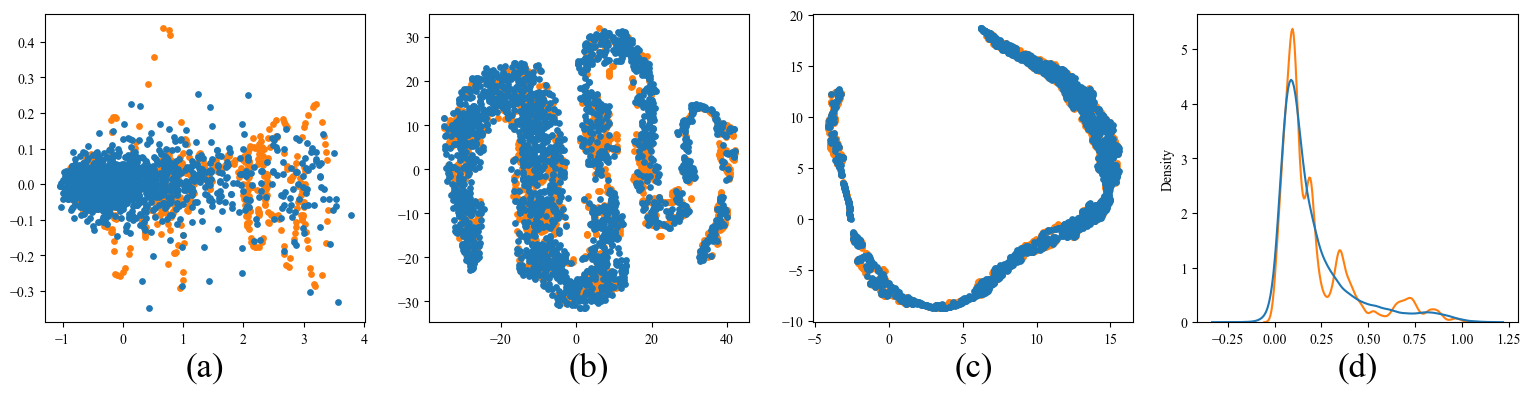

In [166]:
visualization2(train_data, x_t.detach().cpu().numpy() )

# flow inversion

In [30]:
'逆推时采样步越多 误差越小'

n_steps = 5
eps = 1e-8
# eps = 0

target = torch.tensor( train_data[0:2000] ).float().cuda()
shape = target.shape
print(shape)

b, c, n, = target.shape

x_t = target

padding_masks = torch.ones(b, c, dtype=bool, device=device)

torch.Size([2000, 30, 6])


In [31]:
d = torch.tensor(1 / n_steps).to(device)
t = torch.linspace( 1-eps, eps, n_steps+1 ).to(device)

# t = torch.arange(1, 0.0, -d).to(device)   # 采样步少的时候这个取法和上面的方法的误差有些不一样 大采样步时误差几乎一样

for i in range(1, len(t)):
    t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))
    d_batch = d.unsqueeze(0).repeat((b,))
    
    with torch.no_grad():
        
        v_pred = ema.ema_model.output(x_t, t_batch, d=d_batch, padding_masks=padding_masks) 

    x_t = x_t - (t[i-1] - t[i]) * v_pred
    

In [32]:
t = torch.linspace( eps, 1-eps , n_steps+1 ).to(device)

for i in range(1, len(t)):
    t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))
    d_batch = d.unsqueeze(0).repeat((b,))
    
    
    with torch.no_grad():
        
        v_pred = ema.ema_model.output(x_t, t_batch, d=d_batch, padding_masks=padding_masks) 

    x_t = x_t + (t[i] - t[i-1]) * v_pred


RMSE tensor(0.0571)


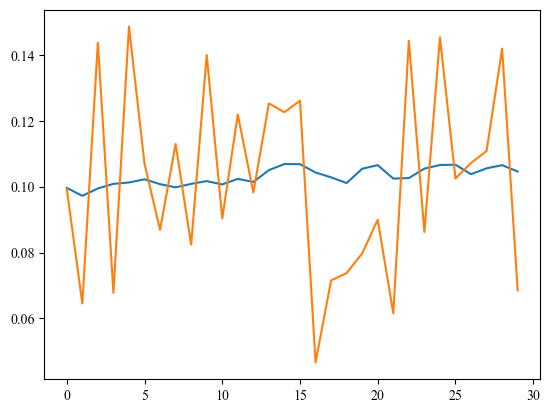

In [33]:
plt.figure()
plt.plot(target[10][:,0].cpu())
plt.plot(x_t[10][:,0].cpu())

rmse = calc_rmse(target, x_t).cpu()
print( 'RMSE', rmse )

# 补全

In [13]:
from torch.autograd import Variable

def get_mask_mcar(sample, mr): 
    mask = torch.ones(sample.shape).view(1,-1) 
    index = torch.tensor(range(mask.shape[1]))  
    perm = torch.randperm(len(index)) 
    index = perm[ 0: round( mr*len(index) ) ]
    mask[0][index]=0
    mask = mask.view(sample.shape)
    return mask


def get_mask_mnr(sample, k):  # 缺失的时候是连续k个点一起缺失 不那么随机 
    mask = torch.ones(sample.shape)
    length_index = torch.tensor(range(mask.shape[0]))
    list_of_segments_index = torch.split(length_index, k)
    for channel in range(mask.shape[1]):
        s_nan = random.choice(list_of_segments_index)
        mask[:, channel][s_nan[0]:s_nan[-1] + 1] = 0

    return mask


def get_mask_bm(sample, k):  # 和上面的类似 也是连续缺失 而且每一列的缺失情况都一样 也就是块缺失
    mask = torch.ones(sample.shape)
    length_index = torch.tensor(range(mask.shape[0]))
    list_of_segments_index = torch.split(length_index, k)
    s_nan = random.choice(list_of_segments_index)
    for channel in range(mask.shape[1]):
        mask[:, channel][s_nan[0]:s_nan[-1] + 1] = 0

    return mask


print( train_data.shape )


(5775, 30, 6)


# 随机初始化隐码

In [64]:
n_steps = 10
eps = 1e-8
# eps = 0

target = torch.tensor( train_data[0:2000] ).float().cuda()
shape = target.shape
print(shape)

b, c, n, = target.shape

code = torch.randn(shape, device=device)
initial_data = Variable( code, requires_grad=True)
optimizer = torch.optim.Adam(  [initial_data], lr=0.001)  
# schedule = torch.optim.lr_scheduler.StepLR( optimizer, step_size=700, gamma=0.1   )
# print(optimizer.param_groups[0]['lr'])

padding_masks = torch.ones(b, c, dtype=bool, device=device)

torch.Size([2000, 30, 6])


In [65]:
mr = 0.3
mechanism = 'mcar'  # or 'mnr'
missing_length = int( mr * Length )
print(mr, missing_length)


Mask = torch.empty([0, c, n])    
print( Mask.shape)


'这种做法保证每个掩码都不同'
for i in range(target.shape[0]):
    if mechanism == 'mcar':
        one_mask = get_mask_mcar( target[0], mr)  
    else:
        one_mask = get_mask_mnr( target[0], missing_length) 

    one_mask = one_mask.unsqueeze(0)   
    Mask = torch.row_stack([Mask, one_mask])

Mask = Mask.float().cuda()
print( Mask.shape )
# Mask[0]

0.3 9
torch.Size([0, 30, 6])
torch.Size([2000, 30, 6])


In [66]:
print( (1-Mask).sum()/( (1-Mask).sum()+Mask.sum() ) )  

tensor(0.3000, device='cuda:0')


In [67]:
d = torch.tensor(1 / n_steps).to(device)
t = torch.linspace(eps, 1 - eps, n_steps+1 ).to(device)

loss_list = []

iteration = 1000
pbar = tqdm( total=iteration )   

for i in range(0,iteration):

    x_t = initial_data

    for i in range(1, len(t)):
        t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))
        d_batch = d.unsqueeze(0).repeat((b,))


        with torch.no_grad():

            v_pred = ema.ema_model.output(x_t, t_batch, d=d_batch, padding_masks=padding_masks) 

        x_t = x_t + (t[i] - t[i - 1]) * v_pred
        
    imp_res = x_t

    loss = F.mse_loss( x_t* Mask, target*Mask, reduction="none")
    loss = loss.sum()/Mask.sum()


    loss.float().backward() 
    optimizer.step()
#     schedule.step()
    optimizer.zero_grad()
    
    loss_list.append(loss.item() )

    pbar.update(1)
    
pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:36<00:00,  2.98it/s]


[0.00030485354363918304, 0.00030444335425272584, 0.0003040358715225011, 0.000303628999972716, 0.00030322346719913185]
[0.017460055659681704, 0.01744830519714525, 0.017436624430276094, 0.017424953370747252, 0.01741331293002948]


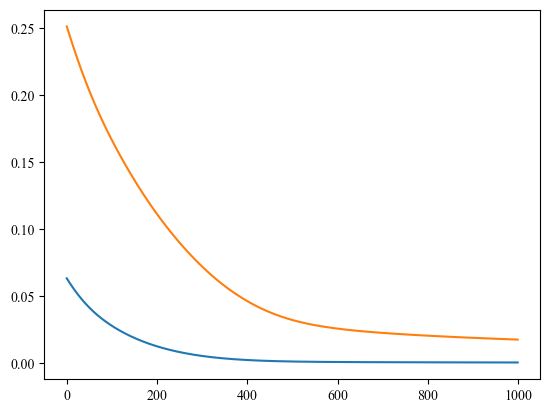

In [68]:
rmse = list( map(lambda x: x ** (1/2), loss_list) )

print( loss_list[-5:]  )
print( rmse[-5:]  )


plt.figure()
plt.plot(loss_list)
plt.plot(rmse)

In [69]:
result = imp_res
rmse = calc_rmse(result, target,1-Mask).cpu()
# mae = calc_mae(result, target, 1-Mask).cpu() 
print( 'RMSE', rmse )
# print( 'MAE', mae)

RMSE tensor(0.0206, grad_fn=<ToCopyBackward0>)


In [171]:
# visualization(ori_data=target.detach().cpu().numpy(), generated_data=imp_res.detach().cpu().numpy(), analysis='pca', compare=train_data.shape[0])

# 使用逆推码

In [15]:
'rmse结果和初始隐码关系恨到 初始隐码越好 rmse越小'
'一个方法是增加采样步 使得逆推码变好'
'有个现象 若初始隐码还原结果的rmse为a 训练后稳定的rmse为a-0.1  就是优化法能减小的rmse为0.01左右'
'另一个方法是改变逆推方法 提高逆推后重构的精确度'
'第三个方法应该是用一个好得预补全方法 得到好的初始值和逆推码'

'有一个结论就是 优化法有极限 不同的初始逆推码 难以优化到同一个近似结果 需要通过更好的预补全 更好的逆推法 来得到更好的逆推码'

'总之 初始值 初始隐码 影响很大 '
'感觉好像更新时 只有观测处在更新 缺失处不怎么更新'


n_steps = 100  # 较小的值时需要一些优化次数 但不能太小 逆推要精确
eps = 1e-8
# eps = 0

target = torch.tensor( train_data ).float().cuda()
shape = target.shape
print(shape)
b, c, n, = target.shape

padding_masks = torch.ones(b, c, dtype=bool, device=device)

torch.Size([5775, 30, 6])


In [16]:
mr = 0.3
mechanism = 'mcar'  
# mechanism = 'mnr' 

missing_length = int( mr * Length )
print(mr, missing_length)

Mask = torch.empty([0, c, n])    
print( Mask.shape)

for i in range(target.shape[0]):
    if mechanism == 'mcar':
        one_mask = get_mask_mcar( target[0], mr)  
    else:
        one_mask = get_mask_mnr( target[0], missing_length) 

    one_mask = one_mask.unsqueeze(0)   
    Mask = torch.row_stack([Mask, one_mask])

Mask = Mask.float().cuda()
print( Mask.shape )

0.3 9
torch.Size([0, 30, 6])
torch.Size([5775, 30, 6])


In [17]:
x_t = target * Mask
x_t[x_t == 0] = np.nan
train_set = {"X": x_t}

In [18]:
from pypots.imputation import SAITS  
from pypots.optim import Adam


saits = SAITS(n_steps=train_data.shape[1], n_features=train_data.shape[2],
              n_layers=2, d_model=256, n_heads=4, d_k=64, d_v=64, d_ffn=128, dropout=0.1, 
#               n_layers=2, d_model=256, n_heads=4, d_k=128, d_v=128, d_ffn=128, dropout=0.1,  # mujoco要增加参数
              num_workers=0, optimizer=Adam(lr=1e-3), 
              batch_size=200, epochs=500, )

saits.fit( train_set = train_set) 

2025-07-25 00:32:39 [INFO]: No given device, using default device: cuda
2025-07-25 00:32:39 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-07-25 00:32:39 [INFO]: Using customized MAE as the training loss function.
2025-07-25 00:32:39 [INFO]: Using customized MSE as the validation metric function.
2025-07-25 00:32:39 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,326,356
2025-07-25 00:32:42 [INFO]: Epoch 001 - training loss (MAE): 0.4535
2025-07-25 00:32:44 [INFO]: Epoch 002 - training loss (MAE): 0.2657
2025-07-25 00:32:46 [INFO]: Epoch 003 - training loss (MAE): 0.2250
2025-07-25 00:32:48 [INFO]: Epoch 004 - training loss (MAE): 0.2035
2025-07-25 00:32:50 [INFO]: Epoch 005 - training loss (MAE): 0.1846
2025-07-25 00:32:53 [INFO]: Epoch 006 - training loss (MAE): 0.1686
2025-07-25 00:32:55 [INFO]: Epoch 007 - training loss (MAE): 0.1517
2025-07-25 00:32:57 [INFO]: Epoch 008 - training loss (

2025-07-25 00:36:53 [INFO]: Epoch 115 - training loss (MAE): 0.0583
2025-07-25 00:36:55 [INFO]: Epoch 116 - training loss (MAE): 0.0577
2025-07-25 00:36:58 [INFO]: Epoch 117 - training loss (MAE): 0.0580
2025-07-25 00:37:00 [INFO]: Epoch 118 - training loss (MAE): 0.0569
2025-07-25 00:37:02 [INFO]: Epoch 119 - training loss (MAE): 0.0568
2025-07-25 00:37:04 [INFO]: Epoch 120 - training loss (MAE): 0.0567
2025-07-25 00:37:06 [INFO]: Epoch 121 - training loss (MAE): 0.0572
2025-07-25 00:37:09 [INFO]: Epoch 122 - training loss (MAE): 0.0572
2025-07-25 00:37:11 [INFO]: Epoch 123 - training loss (MAE): 0.0580
2025-07-25 00:37:13 [INFO]: Epoch 124 - training loss (MAE): 0.0588
2025-07-25 00:37:15 [INFO]: Epoch 125 - training loss (MAE): 0.0568
2025-07-25 00:37:18 [INFO]: Epoch 126 - training loss (MAE): 0.0564
2025-07-25 00:37:20 [INFO]: Epoch 127 - training loss (MAE): 0.0569
2025-07-25 00:37:22 [INFO]: Epoch 128 - training loss (MAE): 0.0564
2025-07-25 00:37:24 [INFO]: Epoch 129 - training

2025-07-25 00:41:22 [INFO]: Epoch 236 - training loss (MAE): 0.0533
2025-07-25 00:41:25 [INFO]: Epoch 237 - training loss (MAE): 0.0529
2025-07-25 00:41:27 [INFO]: Epoch 238 - training loss (MAE): 0.0526
2025-07-25 00:41:29 [INFO]: Epoch 239 - training loss (MAE): 0.0523
2025-07-25 00:41:31 [INFO]: Epoch 240 - training loss (MAE): 0.0522
2025-07-25 00:41:33 [INFO]: Epoch 241 - training loss (MAE): 0.0523
2025-07-25 00:41:35 [INFO]: Epoch 242 - training loss (MAE): 0.0525
2025-07-25 00:41:38 [INFO]: Epoch 243 - training loss (MAE): 0.0553
2025-07-25 00:41:40 [INFO]: Epoch 244 - training loss (MAE): 0.0579
2025-07-25 00:41:42 [INFO]: Epoch 245 - training loss (MAE): 0.0550
2025-07-25 00:41:44 [INFO]: Epoch 246 - training loss (MAE): 0.0545
2025-07-25 00:41:46 [INFO]: Epoch 247 - training loss (MAE): 0.0528
2025-07-25 00:41:49 [INFO]: Epoch 248 - training loss (MAE): 0.0530
2025-07-25 00:41:51 [INFO]: Epoch 249 - training loss (MAE): 0.0527
2025-07-25 00:41:53 [INFO]: Epoch 250 - training

2025-07-25 00:45:48 [INFO]: Epoch 357 - training loss (MAE): 0.0518
2025-07-25 00:45:51 [INFO]: Epoch 358 - training loss (MAE): 0.0515
2025-07-25 00:45:53 [INFO]: Epoch 359 - training loss (MAE): 0.0512
2025-07-25 00:45:55 [INFO]: Epoch 360 - training loss (MAE): 0.0512
2025-07-25 00:45:57 [INFO]: Epoch 361 - training loss (MAE): 0.0515
2025-07-25 00:45:59 [INFO]: Epoch 362 - training loss (MAE): 0.0508
2025-07-25 00:46:02 [INFO]: Epoch 363 - training loss (MAE): 0.0508
2025-07-25 00:46:04 [INFO]: Epoch 364 - training loss (MAE): 0.0514
2025-07-25 00:46:06 [INFO]: Epoch 365 - training loss (MAE): 0.0511
2025-07-25 00:46:08 [INFO]: Epoch 366 - training loss (MAE): 0.0509
2025-07-25 00:46:10 [INFO]: Epoch 367 - training loss (MAE): 0.0512
2025-07-25 00:46:13 [INFO]: Epoch 368 - training loss (MAE): 0.0515
2025-07-25 00:46:15 [INFO]: Epoch 369 - training loss (MAE): 0.0512
2025-07-25 00:46:17 [INFO]: Epoch 370 - training loss (MAE): 0.0512
2025-07-25 00:46:19 [INFO]: Epoch 371 - training

2025-07-25 00:50:15 [INFO]: Epoch 478 - training loss (MAE): 0.0503
2025-07-25 00:50:18 [INFO]: Epoch 479 - training loss (MAE): 0.0500
2025-07-25 00:50:20 [INFO]: Epoch 480 - training loss (MAE): 0.0501
2025-07-25 00:50:22 [INFO]: Epoch 481 - training loss (MAE): 0.0498
2025-07-25 00:50:24 [INFO]: Epoch 482 - training loss (MAE): 0.0499
2025-07-25 00:50:27 [INFO]: Epoch 483 - training loss (MAE): 0.0497
2025-07-25 00:50:29 [INFO]: Epoch 484 - training loss (MAE): 0.0500
2025-07-25 00:50:31 [INFO]: Epoch 485 - training loss (MAE): 0.0496
2025-07-25 00:50:33 [INFO]: Epoch 486 - training loss (MAE): 0.0501
2025-07-25 00:50:35 [INFO]: Epoch 487 - training loss (MAE): 0.0521
2025-07-25 00:50:38 [INFO]: Epoch 488 - training loss (MAE): 0.0510
2025-07-25 00:50:40 [INFO]: Epoch 489 - training loss (MAE): 0.0501
2025-07-25 00:50:42 [INFO]: Epoch 490 - training loss (MAE): 0.0502
2025-07-25 00:50:44 [INFO]: Epoch 491 - training loss (MAE): 0.0507
2025-07-25 00:50:47 [INFO]: Epoch 492 - training

In [19]:
result = saits.predict(train_set)
result = result["imputation"]
print(result.shape)

rmse = calc_rmse(result, target.cpu().numpy(), 1-Mask.cpu().numpy())
mae = calc_mae(result, target.cpu().numpy(), 1-Mask.cpu().numpy())  
print(rmse, mae )

(5775, 30, 6)
0.016939230451855056 0.00996695940055315


In [20]:
# x_t = torch.tensor(result).cuda()
x_t = torch.tensor(result).cuda()*(1- Mask) + target*Mask

In [21]:
d = torch.tensor(1 / n_steps).to(device)
t = torch.linspace( 1-eps, eps, n_steps+1 ).to(device)
# t = torch.arange(1, 0.0, -d).to(device)   # 采样步少的时候这个取法和上面的方法的误差有些不一样 大采样步时误差几乎一样

for i in range(1, len(t)):
    t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))
    d_batch = d.unsqueeze(0).repeat((b,))
    with torch.no_grad():
        v_pred = ema.ema_model.output(x_t, t_batch, d=d_batch, padding_masks=padding_masks) 
    x_t = x_t - (t[i-1] - t[i]) * v_pred
    

initial_code = Variable( x_t, requires_grad=True)
optimizer = torch.optim.Adam(  [initial_code], lr=0.001)  
padding_masks = torch.ones(b, c, dtype=bool, device=device)

In [22]:
loss_list = []
loss_missing_list = []

iteration = 3
pbar = tqdm( total=iteration )   

t = torch.linspace( eps, 1-eps , n_steps+1 ).to(device)

for i in range(0,iteration):
    
    x_t = initial_code
    
    for i in range(1, len(t)):
        t_batch = t[ i-1 ].unsqueeze(0).repeat((b,))
        d_batch = d.unsqueeze(0).repeat((b,))

        with torch.no_grad():
            v_pred = ema.ema_model.output(x_t, t_batch, d=d_batch, padding_masks=padding_masks) 

        x_t = x_t + (t[i] - t[i - 1]) * v_pred
        
    imp_res = x_t

#     loss = F.mse_loss( x_t*Mask , target*Mask , reduction="mean")
    
    loss = F.mse_loss( x_t*Mask , target*Mask , reduction="none")
    loss = loss.sum()/Mask.sum()
    
    
    loss_missing = F.mse_loss( x_t*(1-Mask), target*(1-Mask), reduction="none")
    loss_missing = loss_missing.sum()/(1-Mask).sum()
    loss_missing_list.append(loss_missing.item() )

    
    loss.float().backward() 
    optimizer.step()
#     schedule.step()
    optimizer.zero_grad()
    
    loss_list.append(loss.item() )

    pbar.update(1)
    
pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:26<00:00,  8.97s/it]


[5.8543053455650806e-05, 4.756838461617008e-05, 3.928339356207289e-05]
[0.007651343245185829, 0.006896983733210488, 0.006267646572843183]
[0.00017305572691839188, 0.00017496773216407746, 0.00017850793665274978]
[0.013155064686971018, 0.013227536889537577, 0.013360686234350007]


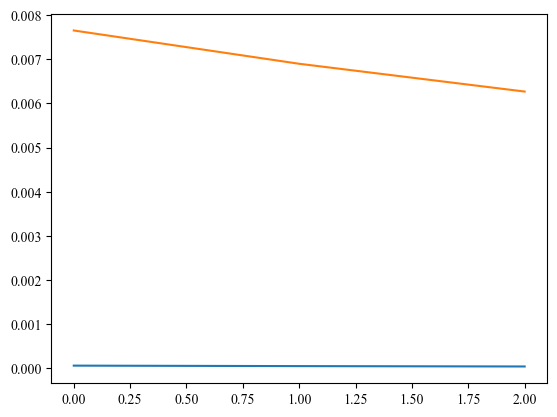

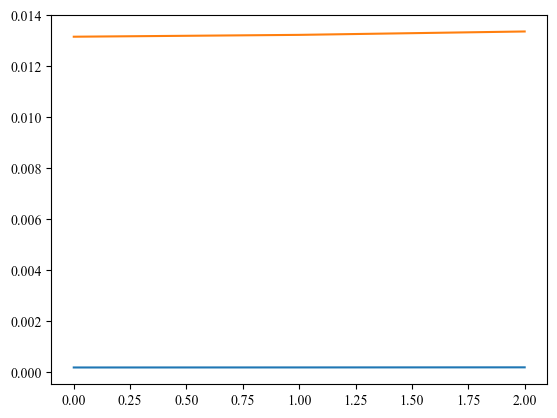

In [23]:
rmse1 = list( map(lambda x: x ** (1/2), loss_list) )
rmse2 = list( map(lambda x: x ** (1/2), loss_missing_list) )
print( loss_list[-5:]  )
print( rmse1[-5:]  )
print( loss_missing_list[-5:]  )
print( rmse2[-5:]  )

plt.figure()
plt.plot(loss_list)
plt.plot(rmse1)

plt.figure()
plt.plot(loss_missing_list)
plt.plot(rmse2)

In [24]:
result = imp_res
rmse = calc_rmse(result, target,1-Mask).cpu()
mae = calc_mae(result, target, 1-Mask).cpu() 
print( 'RMSE', rmse )
print( 'MAE', mae)

RMSE tensor(0.0134, grad_fn=<ToCopyBackward0>)
MAE tensor(0.0073, grad_fn=<ToCopyBackward0>)


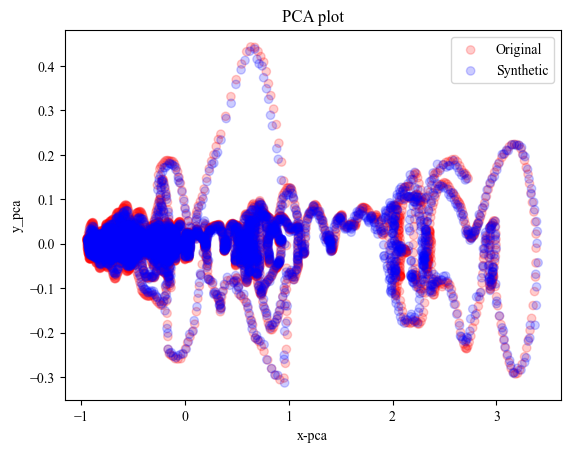

In [25]:
visualization(ori_data=target.detach().cpu().numpy(), generated_data=x_t.detach().cpu().numpy(), analysis='pca', compare=train_data.shape[0])